# Breast Historology Image Analysis

## Binary image classification - IDC vs. Non-IDC samples

Spencer Bertsch <br>
ENGG 192 <br>
Dartmouth College - Winter 2019

The data source for this notebook is the [Breast Historology Dataset](https://www.kaggle.com/simjeg/lymphoma-subtype-classification-fl-vs-cll) from Kaggle. 

IDC, or "invasive ductal carcinoma" is a type of breast cancer which is generally detectable using historology image analysis. However, early detection still poses a challenge. 

Sources: <br> 

One of the [Kernals](https://www.kaggle.com/raoulma/cancer-image-tensorflow-cnn-80-valid-acc/data) written by [Raul Malm](https://www.kaggle.com/raoulma) was extremely helpful when I was begininng my thouhgts about how to construct the netowrk. The discussion on Kaggle also helped - many members of the deep learning community have commented on ways they think that current benchmarks can be improved and it was helpful to see their feedback. 

In addition to simply discussing best practices for convolutional neural netowrks, I will also go over methods for solving data scarsity problems in deep learning contexts. 

[Machine Learning Mastery - Image Augmentation](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/) - This was a very helpful source for learning how to encode domain knowledge nby augmenting the images in the training set via brightness changes, rotations, translations, crops, etc. 

Another helpful source was [EctSang's Github](https://github.com/Ectsang/3D-CNN-Keras/blob/master/3d-cnn-action-recog-keras.py) in which he discusses 3D CNNs in detail and ways for improving convolutional networks when run on color images or color video. 



In [223]:
#IMPORTS 
# --- Standard imports --- 
import numpy as np
import pandas as pd

# --- Deep learning --- 
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, Activation
from keras.layers import Dropout, Input, BatchNormalization
from keras.models import Model
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils, generic_utils

# --- Data Processing --- 
import keras.preprocessing.image
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# --- Model Evaluation --- 
import sklearn.metrics
from sklearn.metrics import confusion_matrix, accuracy_score

# --- Plotting --- 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm  
%matplotlib inline

# --- Other Imports --- 
import datetime  
import time
from keras import backend as K

In [51]:
## import data

# load images of shape (5547, 50, 50, 3)
x_images = np.load('/Users/spencerbertsch/Desktop/ENGG 192/CNN/breast_historology_data/X.npy')  

# load labels of shape (5547,1); (0 = no cancer, 1 = cancer)
y_images = np.load('/Users/spencerbertsch/Desktop/ENGG 192/CNN/breast_historology_data/Y.npy')   

# shuffle data
perm_array = np.arange(len(x_images))
np.random.shuffle(perm_array)
x_images = x_images[perm_array]
y_images = y_images[perm_array]

print('We can examine the shape of our training images:', x_images.shape)
print("We can see that we have",x_images.shape[0], 'training images')
print("And each image is", x_images.shape[1], "by", x_images.shape[2] ,'pixels')
print("Finally, we can see that each pixel contains", x_images.shape[3], "units, representing RGB values.")
print("This means each of our images is in color, and not greyscale")

We can examine the shape of our training images: (5547, 50, 50, 3)
We can see that we have 5547 training images
And each image is 50 by 50 pixels
Finally, we can see that each pixel contains 3 units, representing RGB values.
This means each of our images is in color, and not greyscale


No IDC


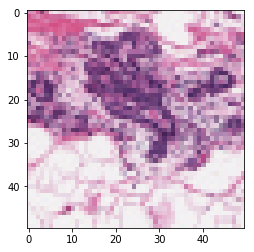

In [117]:
#By changing 'temp' we can sweep through the images and look at cancerous historology results or non-cancerous results

temp = 1
# y_images = 0 represents no cancer, y_images = 1 represents cancer
if(y_images[temp] == 0):
    C = "No IDC"
else:
    C = "IDC"

print(C)
fig = plt.imshow(imgs_0[temp, :, :, :]);

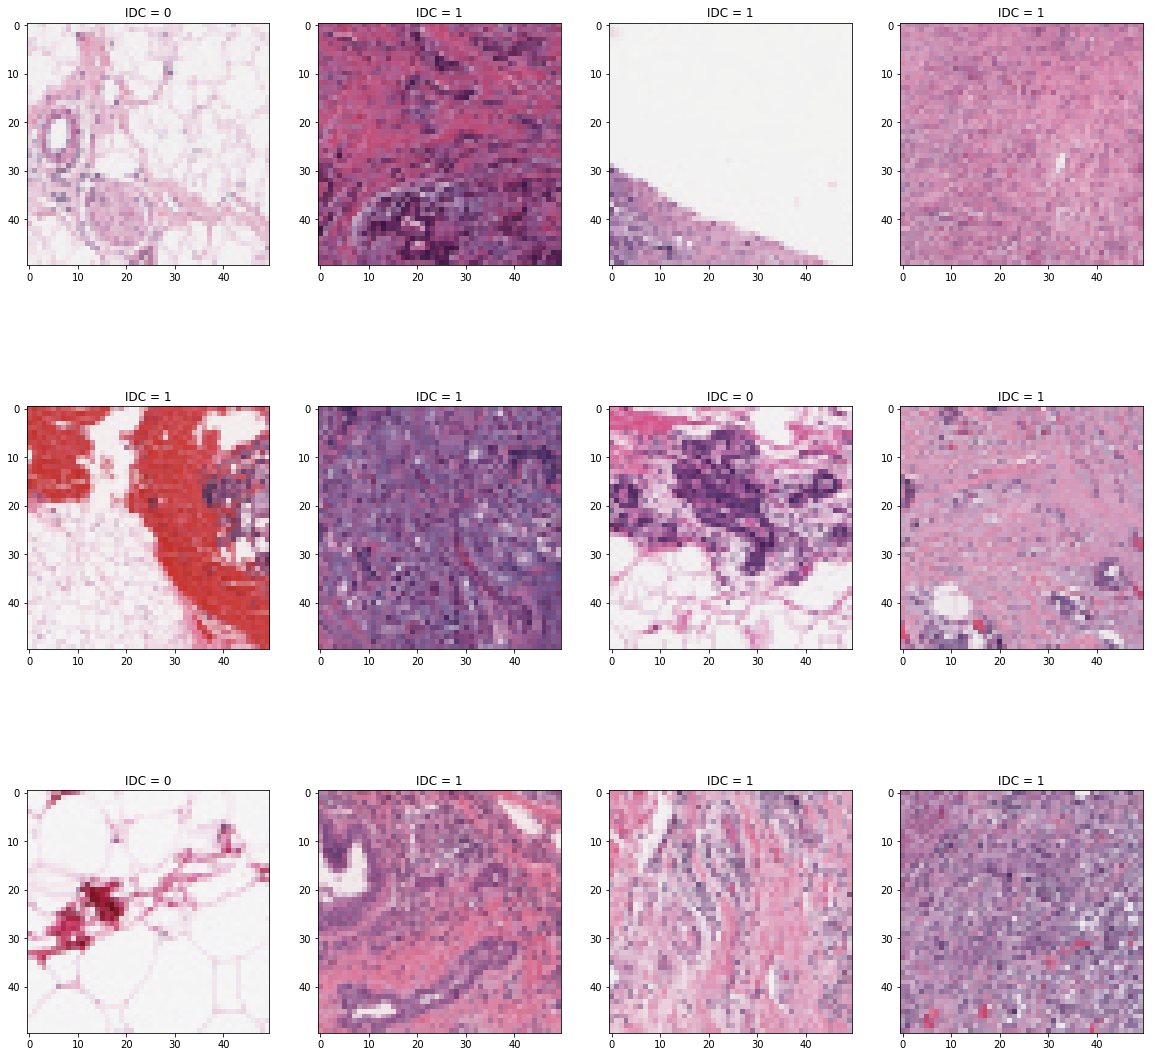

In [50]:
imgs_0 = x_images[y_images == 0] # 0 = no cancer
imgs_1 = x_images[y_images == 1] # 1 = cancer

plt.figure(figsize=(20,20))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.title('IDC = %d'%y_images[i])
    plt.imshow(x_images[i])

# Encoding Domain Knowledge

---------

Oftentimes in deep learning we find ourselves without access to the amount of data we need to train a model to reach desired performance. This lack of data can be due to one of many reasons: lack of funding, lack of time, not enough resources or personell, or perhaps the data simply doesn't exist. 

In order to help solve this problem, we can borrow an idea from classical machine learning and use a method called **Encoding Doman Knowledge** to allow our model to learn the most that it can from the data we have access to. 

One commonly used method for encoding domain knowledge for image classification is mirroring, or flipping each image in the training set horizontally and adding those images to the training data, effectively doubling its size. Most objects in the world are invariant to mirroring, meaning that even when flipped horizontally, they still represent the same object. Four main methods used for encoding domain knowledge are: 

    -Mirroring
    -Translation
    -Scaling
    -Illumination 



As discussed above, mirroring is a technique which simply flips the image horizontally. There is some inherant redundancy in the data when this is performed, but becasue this technique doubles the size of the training data, its often used as a way to increase the relative size of the training data available. Translation is a method in which each image is translated on one direction and then cropped to generate another, similar image to the original. Cosidering this method will show that any type of cropping will casue some of the original data to be lost. Becasue the cropped images will be smaller than the original, several methods can be used to generate replacement data for the edges that were removed; one common practive is simply to take the greyscale or RGB value of the edge data and extend it to the original size of the image, rendering the cropped image back to its original size. 

Scaling is a method in which parts of the image are "zoomed in" and cropped so that the object being recognized is still within the image. When using this method, it's very important that the object being recognized is not accidentally cropped out of the image, or the model will be taught that a simple background shows evidence of the target object. Lastly, illumination can be used to artificially change the light source or brightness to show that objects should still be recognized under different lighting conditions. 

In this script, we will initially train our network directly from the training data, with no use of encoding domain knowledge. After finding a network which performs relatively well, I will use one or more of the techniques discussed above to aritficially increase the size of our training set. I will use this new training set to re-train a network of the same construction, and compare the results of each network. 

In addition to these techniques, we can also rely on more developed techniques such as fine tuning - once the network has already been trained with general data, we develop the model by trianing it on a more focused dataset comprised of only domain specific images. This method is not always applicable, however, becasue public datasets sometimes do not contain data for the tasks at hand. We can also use transfer learning XXX. 

In [93]:
def mirror_images(imgs):
    
    # rotations, translations, zoom
    image_mirror = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)

    # get transformed images
    imgs = image_mirror.flow(imgs.copy(), np.zeros(len(imgs)),
                                batch_size=len(imgs), shuffle = False).next()    
    return imgs[0]

# Deep Learning 
-------
### Using a CNN to classify images as either IDC or non-IDC



## Network Parameters

In [238]:
# Training image shape and specs 
print(x_images.shape)

# image specification
img_rows,img_cols,img_depth=x_images.shape[1],x_images.shape[2],x_images.shape[3]

patch_size = 3    # img_depth

batch_size = 16
nb_classes = 2
nb_epoch = 5

# Our label vector is currently binary, so we need to convert it to a one hot encoded matrix using np.utils
Y_train = np_utils.to_categorical(y_images, nb_classes)

# number of convolutional filters to use at each layer
nb_filters = [  32,   # 1st conv layer
                32]   # 2nd conv layer

# level of pooling to perform at each layer (POOL x POOL)
nb_pool = [3, 3]

# level of convolution to perform at each layer (CONV x CONV)
nb_conv = [3,3]

(5547, 50, 50, 3)


## Image features

This gives us information about how we need to structure the initial convolutional layer in the network 

In [240]:
#Image features
print(nb_filters[0], 'filters')
print('Input Shape:', x_images.shape)
print('Rows:', img_rows)
print('Columns:', img_cols)
print('Patch Size:', patch_size)

32 filters
Input Shape: (5547, 50, 50, 3)
Rows: 50
Columns: 50
Patch Size: 3


## Define the network 

We're now ready to define the model - here we only use one convolutional layer, but note that this problem would be solved with a much higher degree of accuracy if more convolutional layers (and pooling layers) were implemented before the results are flattened and fed to a dense, fully connected layer. 

In [241]:
model = Sequential()

model.add(Conv3D(
    nb_filters[0],
    kernel_dim1 = nb_conv[0], # depth
    kernel_dim2 = nb_conv[0], # rows
    kernel_dim3 = nb_conv[0], # cols
    input_shape=(1, img_rows, img_cols, patch_size),
    activation='relu'
))

model.add(MaxPooling3D(pool_size=(nb_pool[0], nb_pool[0], nb_pool[0]), dim_ordering="tf"))

model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, init='normal', activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(nb_classes,init='normal'))

model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['mse', 'accuracy'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(32, (3, 3, 3), input_shape=(1, 50, 50..., activation="relu")`
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(3, 3, 3), data_format="channels_last")`
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="normal")`
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, kernel_initializer="normal")`


## Split data

We can now use the handy Sklearn package train_test_split to divide our data into training and testing sets

In [242]:
# Split the data
x_data = x_images 

x_data1 = x_data.reshape(x_data.shape[0], 1, img_rows, img_cols, 3)

X_train_new, X_val_new, y_train_new,y_val_new = train_test_split(x_data1, Y_train, test_size=0.2, random_state=4)

print("X_train shape:", X_train_new.shape)
print("y_train shape:", y_train_new.shape)

X_train shape: (4437, 1, 50, 50, 3)
y_train shape: (4437, 2)


In [243]:
# Fitting parameters

## Model Training

Finally, we can train our model on the trianing data and store the performance metrics in Keras history logs 

In [244]:
tic = time.time()
# Train the model
hist = model.fit(
    X_train_new,
    y_train_new,
    validation_data=(X_val_new,y_val_new),
    batch_size = batch_size,
    nb_epoch = nb_epoch,
    shuffle=True
    )

toc = time.time()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 4437 samples, validate on 1110 samples
Epoch 1/5
4437/4437 [==============================] - 187s 42ms/step - loss: 8.0281 - mean_squared_error: 0.4985 - acc: 0.5015 - val_loss: 8.0300 - val_mean_squared_error: 0.4982 - val_acc: 0.5018
Epoch 2/5
4437/4437 [==============================] - 186s 42ms/step - loss: 7.9997 - mean_squared_error: 0.4971 - acc: 0.5028 - val_loss: 8.0300 - val_mean_squared_error: 0.4982 - val_acc: 0.5018
Epoch 3/5
4437/4437 [==============================] - 194s 44ms/step - loss: 8.0108 - mean_squared_error: 0.4972 - acc: 0.5028 - val_loss: 8.0300 - val_mean_squared_error: 0.4982 - val_acc: 0.5018
Epoch 4/5
4437/4437 [==============================] - 190s 43ms/step - loss: 8.0136 - mean_squared_error: 0.4972 - acc: 0.5028 - val_loss: 8.0300 - val_mean_squared_error: 0.4982 - val_acc: 0.5018
Epoch 5/5


In [250]:
# We can use the 'time' package to measure how long it takes to train the model
train_time = toc - tic
secs = train_time%60
mins = (train_time - secs)/60

print('Time taken to train on', nb_epoch, 'epochs was:', mins, 'minutes and', secs, 'seconds.')

Time taken to train on 5 epochs was: 15.0 minutes and 30.746047019958496 seconds.


# Model Evaluation 
-------


In [255]:
# Evaluate the model
score = model.evaluate(
    X_val_new,
    y_val_new,
    batch_size=batch_size,
    #show_accuracy=True
    )

print('Accuracy = ', score[2]*100)

1110/1110 [==============================] - 3s 3ms/step
Accuracy =  50.18018018018018


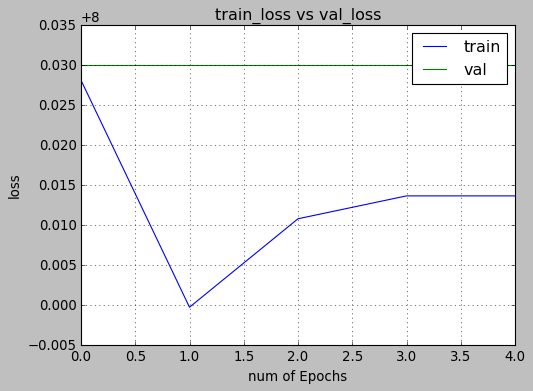

In [263]:
# Plot the results
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(5)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])



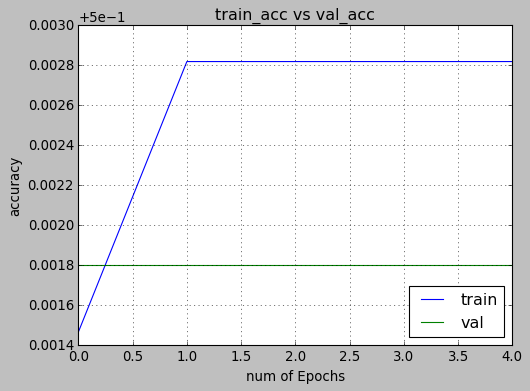

In [262]:
plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
#plt.style.use(['classic'])

# Closing remarks 

Because we only used one convolutional layer, our network was only able to achieve an accuracy of 50.18% for the validation set. This represents a challenging problem, but using deeper networks with more convloutional and pooling layers would yeild better model performance. This will be a work in progress and I will continue to improve this model as I learn more about convolutional neural networks and network regularization techniques. 